# Bianco's CNN color constancy model recreated

#### CS 7180 - Advanced Perception
#### Di Zhang & Prakriti Pritmani
#### Oct 14, 2023

## imported packages

In [2]:
import cv2
import scipy.io
import glob
from random import randint
import progressbar as pb
import h5py
import numpy as np
import tensorflow as tf
from tensorflow import keras

from keras import layers, optimizers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.initializers import glorot_uniform
from keras import backend as K
from keras.preprocessing import image
from keras.models import model_from_json


## Helper Functions

In [3]:
#define progress timer class
class progress_timer:

    def __init__(self, n_iter, description="Something"):
        self.n_iter         = n_iter
        self.iter           = 0
        self.description    = description + ': '
        self.timer          = None
        self.initialize()

    def initialize(self):
        #initialize timer
        widgets = [self.description, pb.Percentage(), ' ',   
                   pb.Bar('=', '[', ']'), ' ', pb.ETA()]
        self.timer = pb.ProgressBar(widgets=widgets, maxval=self.n_iter).start()

    def update(self, q=1):
        #update timer
        self.timer.update(self.iter)
        self.iter += q

    def finish(self):
        #end timer
        self.timer.finish()
        

## Data Preprocesssing

In [4]:
def generate_data(train_size, patch_size, mode):

    path = ""
    mat_path = '/Users/dizhang/Code/NEU/CS7180_Advanced_Perception/assignment/CS7180_Bianco_CNN_CC_model/NikonD40_gt.mat'

    if mode == "train":
        path = '/Users/dizhang/Code/NEU/CS7180_Advanced_Perception/assignment/CS7180_Bianco_CNN_CC_model/RAW_train/'
    elif mode == "test":
        path = '/Users/dizhang/Code/NEU/CS7180_Advanced_Perception/assignment/CS7180_Bianco_CNN_CC_model/RAW_test/'
    else:
        print("wrong mode") 

    illum_mat = scipy.io.loadmat(mat_path, squeeze_me = True, struct_as_record = False)
    ground_truth_illum = illum_mat['groundtruth_illuminants']
    
    flist = glob.glob(path + '*.NEF')
    number_of_gt = len(flist)
    
    pt = progress_timer(n_iter = number_of_gt, description = 'Generating Training Data :')
    
    patches_per_image = int(train_size/number_of_gt)

    X_origin, Y_origin, name_train = [], [], []
    i = 0
    patch_r, patch_c = patch_size

    while (i < number_of_gt):
        
        image_number = flist[i]
        index = (image_number.replace(path ,'')).replace('.NEF', '').replace('NikonD40_', '')
        
        image = cv2.imread(image_number)
        n_r, n_c, _ = np.shape(image)
        total_patch = int(((n_r - n_r%patch_r)/patch_r)*((n_c - n_c%patch_c)/patch_c))
        
        img_resize = cv2.resize(image, ((n_r - n_r%patch_r), (n_c - n_c%patch_c)))
        img_reshape = np.reshape(img_resize, (int(patch_r), -1, 3))
        
        #Create CLAHE object
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    
        for j in range (0, patches_per_image):
            
            rd = randint(0, total_patch - 1)
            img_patch = img_reshape[0:patch_r, rd*patch_c:(rd+1)*patch_c]
            
            #Convert image to Lab to perform contrast normalizing
            lab= cv2.cvtColor(img_patch, cv2.COLOR_BGR2LAB)
            
            #Contrast normalizing(Stretching)
            l, a, b = cv2.split(lab)
            cl = clahe.apply(l)
            clab = cv2.merge((cl, a, b))
            
            #Convert back to BGR
            img_patch = cv2.cvtColor(clab, cv2.COLOR_LAB2BGR)
            
            img_patch = cv2.cvtColor(img_patch, cv2.COLOR_BGR2RGB)
            
            X_origin.append(img_patch)
            Y_origin.append(ground_truth_illum[int(index) - 1])
        
        name_train.append('%04d' % (int(index) - 1))
             
        i += 1
        
        pt.update()
 
    X_origin = np.asarray(X_origin)
    Y_origin = np.asarray(Y_origin)
    
    X_origin = X_origin/255
    max_Y = np.amax(Y_origin, 1)
    Y_origin[:, 0] = Y_origin[:, 0]/max_Y
    Y_origin[:, 1] = Y_origin[:, 1]/max_Y
    Y_origin[:, 2] = Y_origin[:, 2]/max_Y
    
    seed = randint(1, 5000)
    np.random.seed(seed)
    X_origin = np.random.permutation(X_origin)
    
    np.random.seed(seed)
    Y_origin = np.random.permutation(Y_origin)
    
    pt.finish()
    
    return X_origin, Y_origin, name_train

In [5]:
train_size = 80000
patch_size = (32, 32)

X_train, Y_train, name_train = generate_data(train_size, patch_size, "train")
np.save('X_train.npy', X_train)
np.save('Y_train.npy', Y_train) 
np.save('name_train.npy', name_train)

Generating Training Data :: 100% [==============================] Time: 0:00:04


In [6]:
test_size = 37000
patch_size = (32, 32)

X_test, Y_test, name_test = generate_data(test_size, patch_size, "test")
np.save('X_test.npy', X_test)
np.save('Y_test.npy', Y_test) 
np.save('Y_test.npy', name_test)

Generating Training Data :: 100% [==============================] Time: 0:00:01


## Model

In [7]:
def ColorNet(input_shape, channels = 3):
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Stage 1
    X = Conv2D(240, (1, 1), strides = (1, 1), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X_input)
    X = BatchNormalization(name = 'bn_conv1')(X)
    
    X = MaxPooling2D((8, 8), strides=(8, 8))(X)
  
    # output layer
    X = Flatten()(X)
    X = Dense(40, activation='relu', name='fc' + str(40))(X);
    X = Dropout(rate = 0.5)(X);
    
    X = Dense(channels, activation=None, name='fc' + str(channels))(X);
    
    # Create model
    color_model = Model(inputs = X_input, outputs = X, name='ColorNet');
    
    return color_model;

## Training

In [8]:
loss_cos_sim = tf.keras.losses.CosineSimilarity()
rmsprop = optimizers.legacy.RMSprop(lr = 0.001, rho=0.9, epsilon=None, decay=0.0);

cc_model = ColorNet(input_shape = X_train.shape[1:4]);
cc_model.compile(optimizer = 'Adam', loss = loss_cos_sim , metrics = ['accuracy']);

estimate = cc_model.fit(X_train, Y_train, validation_split = 0.3333, epochs = 20, batch_size = 160);

preds = cc_model.evaluate(X_test, Y_test);
print();
print ("Loss = " + str(preds[0]));
print ("Test Accuracy = " + str(preds[1]));

# serialize model to JSON
model_json = cc_model.to_json()
with open("cc_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
cc_model.save_weights("cc_model.h5")
print("Saved model to disk")
 

/Users/dizhang/Code/NEU/CS7180_Advanced_Perception/assignment/CS7180_Bianco_CNN_CC_model/.venv/lib/python3.11/site-packages/keras/src/optimizers/legacy/rmsprop.py:144: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/20
334/334 [==============================] - 35s 105ms/step - loss: -0.9665 - accuracy: 0.9111 - val_loss: -0.9904 - val_accuracy: 0.9738
Epoch 2/20
334/334 [==============================] - 35s 106ms/step - loss: -0.9876 - accuracy: 0.9679 - val_loss: -0.9940 - val_accuracy: 0.9738
Epoch 3/20
334/334 [==============================] - 35s 106ms/step - loss: -0.9914 - accuracy: 0.9703 - val_loss: -0.9964 - val_accuracy: 0.9738
Epoch 4/20
334/334 [==============================] - 36s 106ms/step - loss: -0.9945 - accuracy: 0.9733 - val_loss: -0.9966 - val_accuracy: 0.9738
Epoch 5/20
334/334 [==============================] - 36s 107ms/step - loss: -0.9950 - accuracy: 0.9715 - val_loss: -0.9968 - val_accuracy: 0.9738
Epoch 6/20
334/334 [==============================] - 36s 106ms/step - loss: -0.9955 - accuracy: 0.9756 - val_loss: -0.9967 - val_accuracy: 0.9738
Epoch 7/20
334/334 [==============================] - 35s 106ms/step - loss: -0.9956 - accuracy: 0.9756 - val_loss: -0

## Constructing Images Based on Trained Model

In [9]:
from scipy.io import loadmat

In [10]:
def get_images_fullpath(img_folder_path, mode):
    """ get all the images for the specified folder

    Args:
        img_folder_path (str): path which contains the images
        img_file_format (str): image file format
    Returns:
        images_fullpath (list):  list of image (full) paths
    """
    if (mode == "NEF"):
        images_fullpath = glob.glob(img_folder_path + "**/*.NEF", recursive=True)
    elif (mode == "CR2"):
        images_fullpath = glob.glob(img_folder_path + "**/*.CR2", recursive=True)

    images_fullpath.sort(key=lambda x: x.split('/')[-1].split('.')[0])
    return images_fullpath

def load_groundtruth_illuminant(file_path):
    """ load ground truth illuminant

    Args:
        file_path (str): path which contains the ground truth illuminant values
    Returns:
        real_rgb (np.array):  ground truth illuminant values
    """

    real_illum = loadmat(file_path)
    real_rgb = real_illum["groundtruth_illuminants"]
    real_rgb = real_rgb / real_rgb[:, 1][:, np.newaxis]  # convert to chromaticity
    return real_rgb

In [11]:
def linear_transform(channel_sRGB, gamma, f, s, T):
    m, n = channel_sRGB.shape;
    channel_linear = channel_sRGB; channel_sRGB_norm = channel_sRGB/255;
    for i in range(0, m):
        for j in range(0, n):
            if (T < channel_sRGB_norm[i][j] < 1):
                channel_linear[i][j] = ((channel_sRGB_norm[i][j] + f)/(1 + f))**(1/gamma);
            elif (0 <= channel_sRGB_norm[i][j] <= T):
                channel_linear[i][j] = channel_sRGB_norm[i][j]/s;
                
    channel_linear = 255*channel_linear; 
    channel_linear[channel_linear > 255] = 255;            
    return channel_linear;

def non_linear_transform(channel, gamma, f, s, t):
    m, n = channel.shape;
    channel_gamma_cor = channel; channel_norm = channel/255;
    for i in range(0, m):
        for j in range(0, n):
            if (t < channel_norm[i][j] < 1):
                channel_gamma_cor[i][j] = (1 + f)*(channel_norm[i][j]**gamma) - f;
            elif (0 <= channel_norm[i][j] <= t):
                channel_gamma_cor[i][j] = s*channel_norm[i][j];
    
    channel_gamma_cor = channel_gamma_cor*255; 
    channel_gamma_cor[channel_gamma_cor > 255] = 255;       
    return channel_gamma_cor;
    

In [12]:
def gamma_decode(B_gamma, G_gamma, R_gamma, decoding_type):
    B_gamma = B_gamma/255; G_gamma = G_gamma/255; R_gamma = R_gamma/255; 
    if decoding_type == 'AdobeRGB':
        #Adobe RGB
        gamma = 1/2.2;
        B_gamma_decode = 255*(B_gamma**(1/gamma)); 
        G_gamma_decode = 255*(G_gamma**(1/gamma));
        R_gamma_decode = 255*(R_gamma**(1/gamma));
        return (B_gamma_decode, G_gamma_decode, R_gamma_decode);
    elif decoding_type == 'sRGB':
        #sRGB
        gamma = 1/2.4;
        f = 0.055; s = 12.92; T = 0.04045;
        B_gamma_inverse = linear_transform(B_gamma, gamma, f, s, T);
        G_gamma_inverse = linear_transform(G_gamma, gamma, f, s, T);
        R_gamma_inverse = linear_transform(R_gamma, gamma, f, s, T);
        return (B_gamma_inverse, G_gamma_inverse, R_gamma_inverse);
    
def gamma_encode(B_channel, G_channel, R_channel, encoding_type):
    B_channel = B_channel/255; G_channel = G_channel/255; R_channel = R_channel/255;
    #Non linear encoding
    if encoding_type == 'AdobeRGB':
        #Adobe RGB
        gamma = 1/2.2;
        if np.all(B_channel <= 0):
            B_gamma_cor = (B_channel**(gamma + 0j));
            B_gamma_cor = 255*(abs(B_gamma_cor));
        else:
            B_gamma_cor = 255*(B_channel**gamma);
            
        if np.all(G_channel <= 0):
            G_gamma_cor = (G_channel**(gamma + 0j));
            G_gamma_cor = 255*(abs(G_gamma_cor));
        else:
            G_gamma_cor = 255*(G_channel**gamma);
            
        if np.all(R_channel <= 0):
            R_gamma_cor = (R_channel**(gamma + 0j));
            R_gamma_cor = 255*(abs(R_gamma_cor));
        else:
            R_gamma_cor = 255*(R_channel**gamma);
        
        return (B_gamma_cor, G_gamma_cor, R_gamma_cor);
    elif encoding_type == 'sRGB':
        #sRGB
        gamma = 1/2.4;
        f = 0.055; s = 12.92; t = 0.0031308;
        B_gamma_cor = non_linear_transform(B_channel, gamma, f, s, t);
        G_gamma_cor = non_linear_transform(G_channel, gamma, f, s, t);
        R_gamma_cor = non_linear_transform(R_channel, gamma, f, s, t);
        return (B_gamma_cor, G_gamma_cor, R_gamma_cor);

In [13]:
# This method loads the trained model and uses local image patches to generate illuminatation estimates for the input image and 
# returns estimated illumination map

def create_illumination_map(image, patch_size):

    # load cc_model
    model_path = '/Users/dizhang/Desktop/NEU/CS7180_Advanced_Perception/assignment/CS7180_Bianco_CNN_CC_model/cc_model.h5'
    model_json_path = '/Users/dizhang/Desktop/NEU/CS7180_Advanced_Perception/assignment/CS7180_Bianco_CNN_CC_model/cc_model.json'

    json_file = open('cc_model.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    
    cc_model = model_from_json(loaded_model_json)
    
    cc_model.load_weights("cc_model.h5")
    cc_model.compile(optimizer='Adam', loss=loss_cos_sim, metrics = ['accuracy'])
    
    n_r, n_c, _ = image.shape
    patch_r, patch_c = patch_size
    
    total_patch = int(((n_r - n_r%patch_r)/patch_r)*((n_c - n_c%patch_c)/patch_c))
    
    img_resize = cv2.resize(image, ((n_r - n_r%patch_r), (n_c - n_c%patch_c)))
    img_reshape = np.reshape(img_resize, (int(patch_r), -1, 3))
    
    illum_estimate = []
    print('Before processing total patches')
    for i in range(total_patch):    
        img_patch = img_reshape[0:patch_r, i*patch_c:(i+1)*patch_c]
        patch_cvt = cv2.cvtColor(img_patch, cv2.COLOR_BGR2RGB)
        patch_cvt = np.expand_dims(patch_cvt, axis=0)
        illum_estimate.append(cc_model.predict(patch_cvt))
    illum_estimate = np.asarray(illum_estimate)
    illum_map = np.reshape(illum_estimate, (int((n_r - n_r%patch_r)/patch_r), int((n_c - n_c%patch_c)/patch_c), 3))
    print('generated illum_map')
    return illum_map

In [14]:
def pool_function(illum_map, pool_size, stride,  mode):
    print('Inside pool_function')
    n_h, n_w, n_c = illum_map.shape
    pool_h, pool_w = pool_size
    stride_h, stride_w = stride
    
    # Define the dimensions of the output
    h_out = int(1 + (n_h - pool_h) / stride_h)
    w_out = int(1 + (n_w - pool_w) / stride_w)
    c_out = n_c
    
    pool_out = np.zeros((h_out, w_out, c_out))
    
    for h in range(h_out):                     
        for w in range(w_out):                 
            for c in range (c_out):            
                
                vert_start = h*stride_h
                vert_end = h*stride_h + pool_h
                horiz_start = w*stride_w
                horiz_end = w*stride_w + pool_w
                    
                slice_window = illum_map[vert_start:vert_end, horiz_start:horiz_end, c]
                    
                if mode == "std":
                    pool_out[h, w, c] = np.std(slice_window)
                elif mode == "average":
                    pool_out[h, w, c] = np.mean(slice_window)
    print('Exit pool_function')
    return pool_out

In [15]:
def local_2_global(image_name, image, patch_size):
    """
    This method returns average of all image patches estimated by the ColorNet model
    """
    print('Inside local_2_global')
    n_r, n_c, _ = image.shape
    
    illum_map = create_illumination_map(image, patch_size)      #patch_size = (32, 32)
    
    #Gaussian Smooting with 5x5 kernel
    illum_map_smoothed = cv2.GaussianBlur(illum_map, (5,5), cv2.BORDER_DEFAULT)
    
    #Perform median pooling
    median_pooling = np.zeros((1, 3))
    median_pooling[0, 0] = np.median(illum_map_smoothed[:, :, 0])
    median_pooling[0, 1] = np.median(illum_map_smoothed[:, :, 1])
    median_pooling[0, 2] = np.median(illum_map_smoothed[:, :, 2])
        
    #Perform avarage pooling 
    n_r, n_c, _ = illum_map.shape
    pool_size = (int(n_r/3), int(n_c/3))
    stride = (int(n_r/3), int(n_c/3))
    average_pooling = pool_function(illum_map, pool_size, stride, mode = 'average')
    
    average_pooling[0, 0] = np.mean(average_pooling[:, :, 0])
    average_pooling[0, 1] = np.mean(average_pooling[:, :, 1])
    average_pooling[0, 2] = np.mean(average_pooling[:, :, 2])
    

    illum_global = median_pooling
    print('Exit local_2_global')
    return illum_global
    

In [16]:
def colornet_white_balancing(img, image_name, patch_size):
    """
    This is an abstract method that performs white balancing using the illumation estimate map generated by the ColorNet model
    """
    print('Inside white_balancing')
    m, n, _ = img.shape
    B_channel, G_channel, R_channel = cv2.split(img)
    Color_space = 'AdobeRGB'
 
    #Undo Gamma Correction
    print('Performing  Gamma Correction')
    B_channel, G_channel, R_channel = gamma_decode(B_channel, G_channel, R_channel, Color_space)
    
    #Compute local illuminant map then aggregate to global illuminant
    print('Started local illuminant map then aggregate to global illuminant')
    illum_global = local_2_global(image_name, img, patch_size)
    print('Ended local illuminant map then aggregate to global illuminant')  
    
    #Gain of red and  blue channels
    alpha = np.max(illum_global)/illum_global[0, 2]
    beta = np.max(illum_global)/illum_global[0, 1]
    ceta = np.max(illum_global)/illum_global[0, 0]
        
    #Corrected Image
    B_cor = alpha*B_channel
    G_cor = beta*G_channel
    R_cor = ceta*R_channel
        
    #Gamma correction to display
    B_cor, G_cor, R_cor = gamma_encode(B_cor, G_cor, R_cor, Color_space)
    B_cor[B_cor > 255] = 255
    G_cor[G_cor > 255] = 255
    R_cor[R_cor > 255] = 255
        
    #Convert to uint8 to display
    B_cor = B_cor.astype(np.uint8)
    G_cor = G_cor.astype(np.uint8)
    R_cor = R_cor.astype(np.uint8)
    img_cor = cv2.merge((B_cor, G_cor, R_cor))
    
    return img_cor

In [17]:
real_rgb = load_groundtruth_illuminant('/Users/dizhang/Code/NEU/CS7180_Advanced_Perception/assignment/CS7180_Bianco_CNN_CC_model/NikonD40_gt.mat')
# print(gt_illum)

In [18]:
db_images = get_images_fullpath(img_folder_path = '/Users/dizhang/Code/NEU/CS7180_Advanced_Perception/assignment/CS7180_Bianco_CNN_CC_model/RAW_test', mode="NEF")
db_images = db_images[:70]
test_image_indexs = np.random.choice(len(db_images), 8)

In [19]:
input_imgs = []
gt_imgs = []
cnn_imgs = []

In [20]:

def convert_to_8bit(arr, clip_percentile):
    arr = np.clip(arr * (255.0 / np.percentile(arr, 100 - clip_percentile, keepdims=True)), 0, 255)
    return arr.astype(np.uint8)

In [21]:
def white_balance_image(img12, bit, Gain_R, Gain_G, Gain_B):    
    img12 = (img12/(2**bit - 1))*100.0; #12bit data
    image = convert_to_8bit(img12, 2.5)
    image = (cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            
    image[:, :, 0] = np.minimum(image[:, :, 0] * Gain_R,255)
    image[:, :, 1] = np.minimum(image[:, :, 1] * Gain_G,255)
    image[:, :, 2] = np.minimum(image[:, :, 2] * Gain_B,255)
            
    gamma = 1/2.2
    image = pow(image, gamma) * (255.0/pow(255,gamma))
    image = np.array(image,dtype=np.uint8)
    image8 = (cv2.cvtColor(image, cv2.COLOR_BGR2RGB));
    
    return image8;

In [22]:
def get_input_image(img12,bit):
    img12 = (img12/(2**bit - 1))*100.0; #12bit data
    image = convert_to_8bit(img12, 2.5)
    image = (cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    gamma = 1/2.2
    image = pow(image, gamma) * (255.0/pow(255,gamma))
    image = np.array(image,dtype=np.uint8)
    image8 = (cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    return image8

In [23]:
%time
bit = 12
patch_size = (32,32)
for it,idx in enumerate(test_image_indexs):
    print(f'---------------- Start of Iteration: {it+1} ----------------')
    # Step 1: Convert 12-bit images to 8-bit images
    img12 = cv2.imread(db_images[idx],cv2.IMREAD_UNCHANGED).astype(np.float32)
    img12 = cv2.resize(img12, (512, 512))
    inp_image = get_input_image(img12.copy(),bit=bit)
    input_imgs.append(inp_image)
    
    # Step 2: Generate Ground truth
    Gain_R= float(np.max(real_rgb[idx]))/float((real_rgb[idx][0]))
    Gain_G= float(np.max(real_rgb[idx]))/float((real_rgb[idx][1]))
    Gain_B= float(np.max(real_rgb[idx]))/float((real_rgb[idx][2]))
    gt_image = white_balance_image(img12, bit, Gain_R, Gain_G, Gain_B)
    gt_imgs.append(gt_image)
    
    #Step 3: Generate ColorNet output
    out_img = colornet_white_balancing(inp_image, 'test', patch_size)
    cnn_imgs.append(out_img)
    print(f'---------------- End of Iteration: {it+1} ----------------')

CPU times: user 1e+03 ns, sys: 1 µs, total: 2 µs
Wall time: 3.1 µs
---------------- Start of Iteration: 1 ----------------
Inside white_balancing
Performing  Gamma Correction
Started local illuminant map then aggregate to global illuminant
Inside local_2_global
Before processing total patches
1/1 [==============================] - 0s 8ms/step
generated illum_map
Inside pool_function
Exit pool_function
Exit local_2_global
Ended local illuminant map then aggregate to global illuminant
---------------- End of Iteration: 1 ----------------
---------------- Start of Iteration: 2 ----------------
Inside white_balancing
Performing  Gamma Correction
Started local illuminant map then aggregate to global illuminant
Inside local_2_global
Before processing total patches
1/1 [==============================] - 0s 7ms/step
generated illum_map
Inside pool_function
Exit pool_function
Exit local_2_global
Ended local illuminant map then aggregate to global illuminant
---------------- End of Iteration: 2 

## Result

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

/var/folders/v9/nypmc_px3rq06tbvfnmbys080000gn/T/ipykernel_57039/1499711966.py:28: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


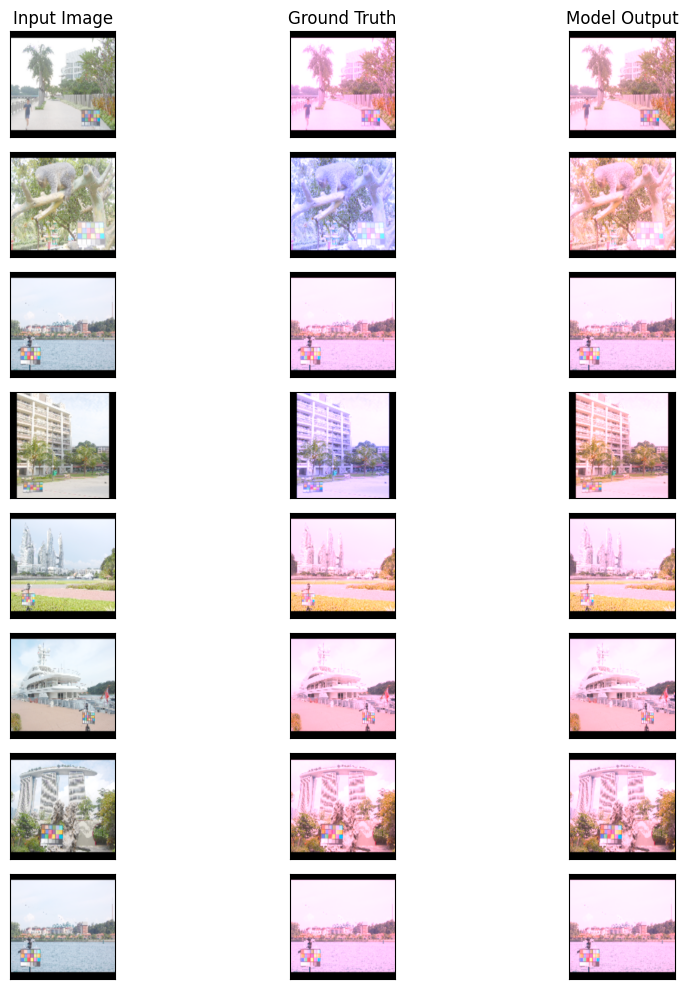

In [25]:
k=1
fig = plt.figure(figsize=(10,10))
for i in range(len(input_imgs)):
    plt.subplot(8,3,k)
    if k==1:
        plt.title("Input Image")
    plt.imshow(cv2.cvtColor(input_imgs[i], cv2.COLOR_BGR2RGB))
    k+=1
    plt.xticks([])
    plt.yticks([])
    plt.subplot(8,3,k)

    if k==2:
        plt.title("Ground Truth")
    plt.imshow(cv2.cvtColor(gt_imgs[i], cv2.COLOR_BGR2RGB))
    k+=1
    plt.xticks([])
    plt.yticks([])
    plt.subplot(8,3,k)
    if k==3:
        plt.title("Model Output")
    plt.imshow(cv2.cvtColor(cnn_imgs[i], cv2.COLOR_BGR2RGB))
    k+=1
    plt.xticks([])
    plt.yticks([])
fig.tight_layout()
# fig.title("Input Image - Ground Truth - Model Output")
fig.show()
fig.savefig(fname='NikonD40.NEF_train_80_epoch_20_trainsize_80000.png')